# Map the Kanshin 2015 yeast data into a Cytoscape node annotation file - October 6, 2016
Similar to the September 29, 2016 analysis but removes peptides that do not exceed the fold change threshold at any time point.

## Create a copy of the yeast data
Only copy the data files if they are needed.  This project is still a work in progress so we want to copy a fixed version of the input data so that the visualization does not change if there are updates in Dylan's repository.  Print the git log to get the commit id for the version of the data that was used.

Now also obtain the significance files.  Instead of using them to create different colors for significant and insignificant peptides, as in the TPS EGFR study, they are used to filter the insignificant peptides.

In [1]:
%%bash
cd C:/Users/agitter/Desktop/bmiToSave/outreach/IBS-SRP2016/dylan/osmotic-stress
git status
git log -1

On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working tree clean
commit 95a7da21945810feb1c3d829e33248add5d79575
Author: Anthony Gitter <gitter@biostat.wisc.edu>
Date:   Fri Sep 30 11:36:41 2016 -0500

    Time series visualization on the TPS network


In [2]:
%pylab inline
import os, shutil, collections
import itertools as it
import pandas as pd

data_dir = os.path.join('..','data','Kanshin2015')
peptide_map_file = os.path.join(data_dir, 'peptide_map.txt')
time_series_file = os.path.join(data_dir, 'peptide_time_series.txt')
sig_peptide_file = os.path.join(data_dir, 'peptide_significance.txt') 

out_dir = os.path.join('..', 'cytoscape', 'yeast_time_series_100616')
network_file = os.path.join(out_dir, 'TPS_network_time_series.cys')
out_file = os.path.join(out_dir, 'cytoscape_time_series.txt')

# Dylan's git repository is the source of the Kanshin 2015 data
data_source_dir = r'C:\Users\agitter\Desktop\bmiToSave\outreach\IBS-SRP2016\dylan\osmotic-stress\Notebooks\Apply Thresholds'
peptide_map_source_file = os.path.join(data_source_dir, 'peptideMap.tsv')
time_series_source_file = os.path.join(data_source_dir, 'timeSeries.tsv')
# The fold change-based pseudo-p-values.  All are 0 or 1.
sig_peptide_source_file = os.path.join(data_source_dir, 'firstScores.tsv')
# Don't need prevScores.tsv it is a placeholder where all p-values are 1

# Can now obtain the Cytoscape source file from the last run
# It has the visual style set up but will require deleting the previous peptide time series before adding the new ones
network_source_file = os.path.join('..', 'cytoscape', 'yeast_time_series_092916', 'TPS_network_time_series.cys')

if not os.path.exists(data_dir):
    print 'Creating {}'.format(data_dir)
    os.makedirs(data_dir)

if not os.path.exists(peptide_map_file):
    print 'Copying {}\nto\n{}\n'.format(peptide_map_source_file, peptide_map_file)
    shutil.copy2(peptide_map_source_file, peptide_map_file)

if not os.path.exists(time_series_file):
    print 'Copying {}\nto\n{}\n'.format(time_series_source_file, time_series_file)
    shutil.copy2(time_series_source_file, time_series_file)

if not os.path.exists(sig_peptide_file):
    print 'Copying {}\nto\n{}\n'.format(sig_peptide_source_file, sig_peptide_file)
    shutil.copy2(sig_peptide_source_file, sig_peptide_file)

if not os.path.exists(out_dir):
    print 'Creating {}'.format(out_dir)
    os.makedirs(out_dir)

if not os.path.exists(network_file):
    print 'Copying {}\nto\n{}\n'.format(network_source_file, network_file)
    shutil.copy2(network_source_file, network_file)

Populating the interactive namespace from numpy and matplotlib
Copying C:\Users\agitter\Desktop\bmiToSave\outreach\IBS-SRP2016\dylan\osmotic-stress\Notebooks\Apply Thresholds\firstScores.tsv
to
..\data\Kanshin2015\peptide_significance.txt

Copying ..\cytoscape\yeast_time_series_092916\TPS_network_time_series.cys
to
..\cytoscape\yeast_time_series_100616\TPS_network_time_series.cys



## Load the peptide significance
First load the temporal peptide significance.  Ignore all peptides that are not significant at one or more time points.  Significant peptides have a pseudo-p-value of 0.

In [3]:
sig_df = pd.read_csv(sig_peptide_file, sep='\t')
sig_df['Min p-value'] = sig_df.ix[:,'T05':'T60'].apply(lambda row: min(row), axis=1)

sig_peptides = set(sig_df.ix[sig_df['Min p-value'] == 0, '#ModifiedPeptideSeq'].values)
# Confirm the number of significant peptides matches a manual analysis in Excel
assert len(sig_peptides) == 1401, 'Unexpected number of significant peptides'
print '{} significant peptides'.format(len(sig_peptides))

sig_df.head(10)

1401 significant peptides


,#ModifiedPeptideSeq,T05,T10,T15,T20,T25,T30,T35,T40,T45,T50,T55,T60,Min p-value
0,NVVDENLINDMDS(ph)EDAHK-18075,1,1,1,1,1,1,1,1,1,1,1,1,1
1,ADDEEDLS(ph)DENIQPELR-18058,1,1,1,1,1,1,1,1,1,1,1,1,1
2,SNS(ph)IDYAK-18078,1,1,1,1,1,1,1,1,1,1,1,1,1
3,QHLSDIT(ph)LEER-18077,1,1,1,1,1,1,1,1,1,1,1,1,1
4,GLDDESGPTHGNDS(ph)GNHR-18068,1,1,1,1,1,1,1,1,1,1,1,1,1
5,LDFVTDDLEYHLANTHPDDT(ph)NDKVESR-18070,1,1,1,1,1,1,1,1,1,1,1,1,1
6,LLS(ph)SHLK-18073,1,0,1,1,1,1,1,1,0,1,1,1,0
7,S(ph)KFEGLAASEKEEEEMENK-9982,0,0,0,0,0,0,0,0,0,0,0,0,0
8,TPS(ph)PAPAAK-9993,1,1,1,1,1,1,1,1,1,1,1,1,1
9,NEKS(ph)PAQLWAER-9974,1,1,1,1,1,1,1,1,1,1,1,1,1


## Load the peptide mapping
Each yeast ORF id maps to a set of peptides.  Ignore all peptides that are not in the signficiant list loaded above.  Plot the number of peptides per ORF.  Some ORFs have 27 peptides before filtering but there are at most 11 after filtering.

Ignored 2936 insignificant peptides
784 unique yeast ORFs
Range of peptides per ORF: 1-11


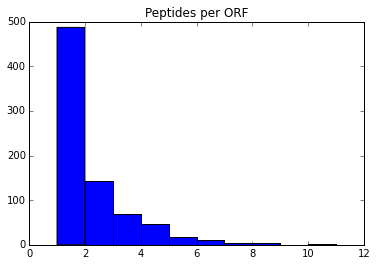

In [4]:
orf_to_peptide_map = collections.defaultdict(set)
peptide_to_orf_map = dict()
ignored = 0

with open(peptide_map_file) as p_file:
    for line in p_file:
        parts = line.strip().split('\t')
        assert len(parts) == 2, 'Expected peptide and ORF'
        
        # Check for peptide significance
        if parts[0] in sig_peptides:
            orf_to_peptide_map[parts[1]].add(parts[0])
            peptide_to_orf_map[parts[0]] = parts[1]
        else:
            ignored += 1


print 'Ignored {} insignificant peptides'.format(ignored)
print '{} unique yeast ORFs'.format(len(orf_to_peptide_map))

peptides_per_orf = [len(peptides) for peptides in orf_to_peptide_map.values()]
print 'Range of peptides per ORF: {}-{}'.format(min(peptides_per_orf), max(peptides_per_orf))

hist(peptides_per_orf);
title('Peptides per ORF');

## Load the peptide time series
Create a map from the ORF to a list of associated time series profiles.  Impute missing data.  If the first time point is missing, set it to 0.  If later time points are missing, set them to the previous observed time point.  Prepend an artificial 0 to all time series to help with the visualization.

In [5]:
# Helper function
# Replaces missing values
# Prepends a 0
# Collapses the list to a string
def clean_ts(time_series):
    if time_series[0] == '':
        time_series[0] = '0'

    for i in range(1, len(time_series)):
        if time_series[i] == '':
            time_series[i] = time_series[i-1]

    time_series.insert(0, '0')

    return ', '.join(time_series)

orf_ts_map = collections.defaultdict(list)
with open(time_series_file) as t_file:
    header = t_file.readline().strip()
    assert header == 'ModifiedPeptideSeq\tT00\tT05\tT10\tT15\tT20\tT25\tT30\tT35\tT40\tT45\tT50\tT55\tT60', 'Unexpected header'
    for line in t_file:
        # Don't strip all whitespace or trailing missing data will be lost
        parts = line.strip('\n').split('\t')
        assert len(parts) == 14
        
        # Find the matching ORF, add this time series to its list
        peptide = parts[0]
        time_series = clean_ts(parts[1:])
        if peptide in sig_peptides:
            assert peptide in peptide_to_orf_map, 'Unexpected peptide: {}'.format(peptide)
            orf = peptide_to_orf_map[peptide]
            orf_ts_map[orf].append(time_series)

# Check missing data handling
missing_orfs = ['YLR131C', 'YIR003W', 'YOL130W']
for orf in missing_orfs:
    print orf
    print '\n'.join(map(str,orf_ts_map[orf]))
    print

YLR131C
0, 0, 0.10540989404, -0.137901762541, -0.111788637486, 0.0366088286051, -0.0109482110892, 0.115699153432, -0.0345001274169, 0.241352085771, 0.37105696835, -0.239157391252, -0.239157391252, -0.00481219123882

YIR003W
0, 0.0673633671196, -0.0167747003336, 0.29054236266, 0.177726482932, 0.240619629312, 0.0147837526271, 0.217975140923, 0.52074909665, 0.46173808602, 0.749062230739, 0.766128674991, 1.25863952114, 0.654435540845
0, -0.115972627768, 0.333652714765, 0.333652714765, 0.0112093614203, 0.0350607969051, 0.0114956388378, 0.139338513601, 0.282261866588, 0.282261866588, 0.282261866588, 0.123401335972, 0.240008964735, 0.441802154629

YOL130W
0, 0.0030264828899, -0.253016568542, 0.203639694014, 0.231923873294, 0.179511050272, 0.282380494639, 0.867105729503, 0.715717689222, 1.29842371193, 1.5278210224, 2.04099760507, 2.24838302943, 2.33247880259
0, -0.0877027092405, -0.242038026687, -0.242038026687, -0.242038026687, -0.389904730513, -0.471648727656, -0.735139336833, -0.73513933683

## Write the time series to a file
Write one column for each possible peptide even though most columns will be mostly empty

In [6]:
cols = max(peptides_per_orf)
header = ['ORF']
# Make a header that is Peptide<i>
header.extend(map(lambda x, y: x + str(y), it.repeat('Peptide',cols), range(1,cols+1)))

with open(out_file, 'w') as o_file:
    o_file.write('\t'.join(header))
    o_file.write('\n')
    for orf in sorted(orf_ts_map.keys()):
        # Each line is the ORF id followed by all comma-separated time series profiles, one per column
        out_line = [orf]
        out_line.extend(orf_ts_map[orf])
        o_file.write('\t'.join(out_line))
        o_file.write('\n')